In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
import matplotlib.pyplot as plt
mx.random.seed(1)

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
ctx = mx.gpu()

In [3]:
batch_size = 64

train_data = mx.io.ImageRecordIter(
    path_imgrec="./listfile-train.rec", # the target record file
    data_shape=(3, 224, 224), # output data shape. An 227x227 region will be cropped from the original image.
    batch_size=batch_size, # number of samples per batch
    label_width=1,
    path_imglist = './listfile-train.lst'
    # ... you can add more augumentation options here. use help(mx.io.ImageRecordIter) to see all possible choices
    )
#train_data = gluon.data.DataLoader(train_data_records,batch_size=batch_size, shuffle=True, last_batch='discard')

test_data = mx.io.ImageRecordIter(
    path_imgrec="./listfile-val.rec", # the target record file
    data_shape=(3, 224, 224), # output data shape. An 227x227 region will be cropped from the original image.
    batch_size=1000, # number of samples per batch
    label_width=1,
    path_imglist = './listfile-val.lst'
    # ... you can add more augumentation options here. use help(mx.io.ImageRecordIter) to see all possible choices
    )


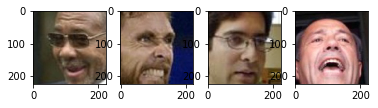

In [4]:
train_data.reset()
batch = train_data.next()
data = batch.data[0]
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.show()


In [5]:
alex_net = gluon.nn.HybridSequential()
with alex_net.name_scope():
    #  First convolutional layer
    alex_net.add(gluon.nn.Conv2D(channels=96, kernel_size=11, strides=(4,4), activation='relu'))
    alex_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))
    #  Second convolutional layer
    alex_net.add(gluon.nn.Conv2D(channels=192, kernel_size=5, activation='relu'))
    alex_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=(2,2)))
    # Third convolutional layer
    alex_net.add(gluon.nn.Conv2D(channels=384, kernel_size=3, activation='relu'))
    # Fourth convolutional layer
    alex_net.add(gluon.nn.Conv2D(channels=384, kernel_size=3, activation='relu'))
    # Fifth convolutional layer
    alex_net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, activation='relu'))
    alex_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))
    # Flatten and apply fullly connected layers
    alex_net.add(gluon.nn.Flatten())
    alex_net.add(gluon.nn.Dense(500, activation="relu"))
    alex_net.add(gluon.nn.Dense(90, activation="relu"))
    alex_net.add(gluon.nn.Dense(10))

In [6]:
alex_net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

In [7]:
trainer = gluon.Trainer(alex_net.collect_params(), 'sgd', {'learning_rate': .001})

In [8]:
alex_net.hybridize()

In [9]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
square_loss = gluon.loss.L2Loss()

In [10]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [11]:
###########################
#  Only one epoch so tests can run quickly, increase this variable to actually run
###########################
epochs = 30
smoothing_constant = .01
test_accuracies = []
train_accuracies = []

for e in range(epochs):
    train_data.reset()
    filename = f"checkpoints/smile_net-{e}.params"
    print("Epoch ", e)
    for i, batch in enumerate(train_data):
        print('.', end='')
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)

        with autograd.record():
            output = alex_net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

    test_accuracy = evaluate_accuracy(test_data, alex_net)
    test_accuracies.append(test_accuracies)
    train_accuracy = evaluate_accuracy(train_data, alex_net)
    train_accuracies.append(train_accuracy)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))
    alex_net.save_params(filename)

Epoch  0
........................................................................................................................................................................Epoch 0. Loss: 1.24747659093, Train_acc 0.592814371257, Test_acc 0.5885
Epoch  1
.......................................................................................................................................................................Epoch 1. Loss: 0.788393456081, Train_acc 0.592540922619, Test_acc 0.5835
Epoch  2
.......................................................................................................................................................................Epoch 2. Loss: 0.692800843538, Train_acc 0.610310628743, Test_acc 0.603
Epoch  3
........................................................................................................................................................................Epoch 3. Loss: 0.661668052789, Train_acc 0.643993263473, Test_acc 0.635
Epoch

In [12]:
from mxnet import sym
x = sym.var('data')
print('=== input data holder ===')
print(x)

y = alex_net(x)
print('\n=== the symbolic program of net===')
print(y)


y_json = y.tojson()
print('\n=== the according json definition===')
print(y_json)

=== input data holder ===
<Symbol data>

=== the symbolic program of net===
<Symbol hybridsequential0_dense2_fwd>

=== the according json definition===
{
  "nodes": [
    {
      "op": "null", 
      "name": "data", 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "hybridsequential0_conv0_weight", 
      "attrs": {
        "__dtype__": "0", 
        "__lr_mult__": "1.0", 
        "__shape__": "(96, 0, 11, 11)", 
        "__wd_mult__": "1.0"
      }, 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "hybridsequential0_conv0_bias", 
      "attrs": {
        "__dtype__": "0", 
        "__init__": "zeros", 
        "__lr_mult__": "1.0", 
        "__shape__": "(96,)", 
        "__wd_mult__": "1.0"
      }, 
      "inputs": []
    }, 
    {
      "op": "Convolution", 
      "name": "hybridsequential0_conv0_fwd", 
      "attrs": {
        "dilate": "(1, 1)", 
        "kernel": "(11, 11)", 
        "layout": "NCHW", 
        "no_bias": "False", 
        "

In [13]:
y.save('smile-net.json')
alex_net.save_params('smile-net.params')